In [1]:
'''
    ------------
    # LIBRARIES #
    ------------
'''

from qat.lang.AQASM import *
from qat.qpus import PyLinalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as pl

In [15]:
'''
    -----------------
    # AUX FUNCTIONS #
    -----------------
'''

def get_cumulants(probs):
    '''calculates the cumulants'''
    dim=np.shape(probs)
    cumulants=np.zeros([dim[0], dim[1]])
    for j in range(len(probs)):
        cumulant=0
        for i in range(len(probs[j])):
            sorted_probs=np.sort(probs[j])[::-1]
            cumulant=cumulant+sorted_probs[i]
            cumulants[j][i]=cumulant
    return cumulants

In [3]:
'''
    ---------------------
    # MATRIX GENERATORS #
    ---------------------
'''

def haar_n(n):
    '''generates a random nxn matrix'''
    z = (np.random.randn(n,n) + 1j*np.random.randn(n,n))/np.sqrt(2.0)
    q,r = np.linalg.qr(z)
    d = np.diagonal(r)
    ph = d/np.absolute(d)
    q = np.multiply(q,ph,q)
    return q

In [4]:
'''
    ------------------
    # ABSTRACT GATES #
    ------------------
'''

def Haar_N(nqbits):
    ''' returns Haar-random unitary from U(2^n). (Attention: no dummy!) '''
    HaarN = AbstractGate("Haar_N", [int], matrix_generator=lambda n: haar_n(2**n), arity=nqbits)
    return HaarN(nqbits)

In [5]:
'''
    ------------
    # INITIAL PARAMETERS #
    ------------
'''

nqbits = 8
pylinalgqpu = PyLinalg()

In [6]:
'''
    ------------
    # PREPARING THE STATE #
    ------------
'''
qprog = Program()
qbits = qprog.qalloc(nqbits)
qprog.apply(Haar_N(nqbits), qbits)

circuit = qprog.to_circ()

%qatdisplay --svg circuit

In [17]:
'''
    ------------
    # CALCULATE EXPECTED STATE #
    ------------
    
'''
expected=np.zeros(2**nqbits)

job = circuit.to_job(nbshots=0)
result = pylinalgqpu.submit(job)

i=0
for sample in result:
    expected[i]=sample.probability
    i = i + 1
    
for i in range(len(expected)):
    expected=np.sort(expected)[::-1]
    
print(expected)

[2.21950047e-02 1.86212471e-02 1.57659207e-02 1.50727255e-02
 1.50564617e-02 1.47691485e-02 1.36700117e-02 1.31401795e-02
 1.31093287e-02 1.23827765e-02 1.23351428e-02 1.20815569e-02
 1.16702990e-02 1.10973848e-02 1.04642662e-02 1.04432095e-02
 1.03478401e-02 1.01819293e-02 9.94234614e-03 9.82391496e-03
 9.75061427e-03 9.54279810e-03 9.47002203e-03 9.41551263e-03
 9.03204839e-03 8.89325500e-03 8.89049423e-03 8.88243336e-03
 8.79581277e-03 8.78804158e-03 8.64110128e-03 8.53469464e-03
 8.41065719e-03 7.90884614e-03 7.73495223e-03 7.69321098e-03
 7.65452171e-03 7.59499969e-03 7.48001356e-03 7.45582178e-03
 7.42134248e-03 7.39599041e-03 7.10843967e-03 7.07817650e-03
 6.81239837e-03 6.71264107e-03 6.67249582e-03 6.62425139e-03
 6.61514948e-03 6.58039156e-03 6.35856852e-03 6.11418067e-03
 6.00803703e-03 5.91480765e-03 5.89801334e-03 5.86545764e-03
 5.68552786e-03 5.68073063e-03 5.66833370e-03 5.48039555e-03
 5.47078607e-03 5.45428732e-03 5.45179830e-03 5.41255392e-03
 5.39710130e-03 5.336371

In [47]:
'''
    ------------
    # SIMULATE MULTIPLE EXPERIMENTS #
    ------------
    Here we simulate multiple experiments where nshots varies and see how that influences the probabilities
'''

nshots=500 # number of experiments done in one trial #
trials=20
probs=[]
results=[]

for i in range(trials):
    job = circuit.to_job(nbshots=nshots, aggregate_data=False)
    result = pylinalgqpu.submit(job)
    for sample in result:
        results.append(sample.state.int)
    prob=(np.histogram(results, bins=2**nqbits)[0])/(nshots*(i+1))
    probs.append(prob)

probs=np.array(probs)    
for j in range(len(probs)):
    for i in range(len(probs[j])):
        sorted_probs=np.sort(probs[j])[::-1]
        probs[j]=sorted_probs
        
print(probs.shape)

(20, 256)


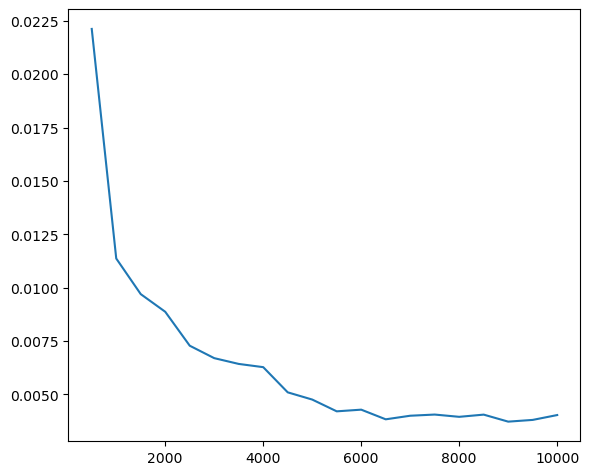

In [48]:
# Let's plot the difference to the expected state as nshots rises #

distances=[]
nmeasure=range(nshots,nshots*(trials+1),nshots)

for prob in probs:
    distance=np.linalg.norm(prob-expected)
    distances.append(distance)

fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.8, 0.9])
#plt.yscale('log')
ax.plot(nmeasure, distances)

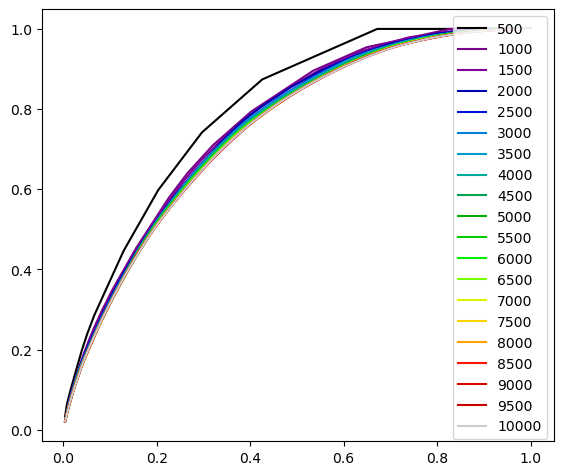

In [49]:
'''
    ------------
    # VARIATION OF THE CUMULANTS #
    ------------
    How the cumulants for 1 circuit change as nshots rises
'''

# Calculate the cumulants #

cumulants=get_cumulants(probs)

# Defining k/N #

rang=len(cumulants[0])+1
bign=np.array(range(rang))/len(cumulants[0])
bign=bign[1:rang]

# Plot the Lorenz curves #

k=len(cumulants)
colors = pl.cm.nipy_spectral(np.linspace(0,1,k))

fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.8, 0.9])
i=0
#plt.yscale('log')
for cumulant in cumulants:
    ax.plot(bign, cumulant, label=nmeasure[i], c=colors[i])
    i=i+1
    
ax.legend()

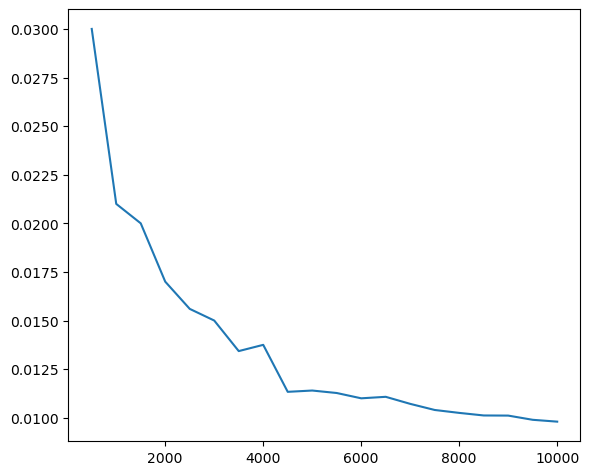

In [50]:
'''
    ------------
    # VARIATION OF THE CUMULANTS 2 #
    ------------
    I plotted the distance between adjacent Lorenz curves to try and determine a saturation point
'''

# Calculate the distances #

distances=[]
i=0
for cumulant in cumulants[0:len(cumulants)]:
    distance=np.linalg.norm(cumulant[i]-cumulant[i+1])
    distances.append(distance)
    i=i+1

# Plot the distances #

fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.8, 0.9])

ax.plot(nmeasure, distances)
